### 1. Load the data


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


column_types = {
    "departamento": "category",
    "municipio": "category",
    "sexo": "category",
    "año_registrado": "category",
    "edad": "int64",
    "periodo": "category",
    "etnia": "category",
    "escolaridad": "category",
    "ocupacion": "category",
    "causa": "category",
    "asistencia": "category",
    "lugar": "category",
}

defunciones = pd.read_csv("defunciones_clean.csv", dtype=column_types)
defunciones.head()

,departamento,municipio,sexo,año_registrado,edad,periodo,etnia,escolaridad,ocupacion,causa,asistencia,lugar
0,17.0,1703,1.0,2012,28,3.0,NaN,1.0,NaN,M329,5.0,6.0
1,1.0,0101,2.0,2012,88,3.0,NaN,2.0,NaN,E142,1.0,6.0
2,1.0,0101,2.0,2012,74,3.0,NaN,2.0,NaN,E039,1.0,1.0
3,1.0,0101,2.0,2012,43,3.0,NaN,2.0,NaN,E149,1.0,6.0
4,1.0,0101,2.0,2012,88,3.0,NaN,2.0,NaN,E119,1.0,6.0


### 2. Preprocessing

1. Simplify ICD10 Code
2. Use age_groups instead of age
3. Handle Missing Values


In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns


def load_codes(file_path):
    with open(file_path, "r") as f:
        codes = json.load(f)
    return {entry["code"]: entry["code"] for entry in codes if entry["level"] == 0}


def simplify_icd10(code, code_map):
    if pd.isna(code):
        return "Unknown"
    code = code.split(".")[0]
    code_prefix = code[:3]
    for code_range in code_map:
        if "-" not in code_range:
            if code_range[:3] == code_prefix:
                return code_map[code_range]
        else:
            start, end = code_range.split("-")
            start_prefix = start[:3]
            end_prefix = end[:3]

            # For example, if the code is 'B014', the prefix is 'B01' and the range is 'B00-B99', so it's a match.
            if start_prefix <= code_prefix <= end_prefix:
                return code_map[code_range]
    return "Other"


def split(defunciones, code_map):
    defunciones = defunciones.dropna()
    defunciones["causa_simplificada"] = defunciones["causa"].apply(
        lambda x: simplify_icd10(x, code_map)
    )

    print("Numero de causas antes de simplificar:", defunciones["causa"].nunique())
    print(
        "Numero de causas despues de simplificar:",
        defunciones["causa_simplificada"].nunique(),
    )

    data = defunciones.copy()
    data = data.drop(columns=["causa"])
    data = data[data["causa_simplificada"] != "Other"]
    data = data.rename(columns={"causa_simplificada": "causa"})

    mode = data["ocupacion"].mode()[0]
    data["ocupacion"] = data["ocupacion"].replace(["NEOG", "IGNORADO"], mode)

    data["age_group"] = pd.cut(
        data["edad"],
        bins=[0, 18, 35, 50, 65, float("inf")],
        labels=["0-18", "19-35", "36-50", "51-65", "65+"],
    )

    data.drop(columns=["edad"], inplace=True)

    # Save the data to a CSV file, called 'defunciones_clean.csv'
    data.to_csv("defunciones_simplified.csv", index=False)

    return data


icd10_codes = load_codes("codes.json")
causes = split(defunciones, icd10_codes)
# causa_counts = analyze_causa_counts(causes)
# print(causes['age_group'].value_counts())

causes.head()

C:\Users\estra\AppData\Local\Temp\ipykernel_5660\3818250419.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defunciones["causa_simplificada"] = defunciones["causa"].apply(
C:\Users\estra\AppData\Local\Temp\ipykernel_5660\3818250419.py:51: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data["ocupacion"] = data["ocupacion"].replace(["NEOG", "IGNORADO"], mode)


Numero de causas antes de simplificar: 3007
Numero de causas despues de simplificar: 20


,departamento,municipio,sexo,año_registrado,periodo,etnia,escolaridad,ocupacion,asistencia,lugar,causa,age_group
70905,14.0,1415,1.0,2013,3.0,1.0,1.0,61,5.0,6.0,K00-K95,65+
70906,14.0,1411,1.0,2013,3.0,1.0,1.0,61,5.0,6.0,K00-K95,65+
70907,16.0,1601,1.0,2013,3.0,1.0,9.0,92,5.0,6.0,K00-K95,65+
70908,1.0,0116,1.0,2013,3.0,9.0,1.0,61,5.0,6.0,K00-K95,65+
70909,12.0,1219,1.0,2013,3.0,4.0,1.0,92,5.0,6.0,K00-K95,65+


### 3. Different Models


In [4]:
def split(X, y):
    X_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42
    )
    return X_train, X_test, y_train, y_test


def create_preprocessor(numeric_features, categorical_features):
    # numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    preprocessor = ColumnTransformer(
        transformers=[
            # ('num', numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )
    return preprocessor


def create_pipeline(preprocessor, model):
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    return pipeline


def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"Confusion Matrix - {model_name}:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        cmap="Blues",
        fmt="d",
        xticklabels=np.unique(y_test),
        yticklabels=np.unique(y_test),
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()
    print(f"Accuracy - {model_name}: {accuracy_score(y_test, y_pred)}\n")


data = causes.copy()

# Sample because the dataset is too large...
data = data.sample(frac=0.1, random_state=42)

X = data.drop("causa", axis=1)
y = data["causa"]

selected_features = X.columns.tolist()
numeric_features = ["edad"]
categorical_features = [feat for feat in selected_features if feat != "edad"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = split(X, y)

# # Create the preprocessing pipeline
preprocessor = create_preprocessor(numeric_features, categorical_features)

# # Create and evaluate different models
# models = [
#     ('Decision Tree', DecisionTreeClassifier(random_state=42)),
#     ('Random Forest', RandomForestClassifier(random_state=42))
# ]

# for model_name, model in models:
#     pipeline = create_pipeline(preprocessor, model)
#     pipeline.fit(X_train, y_train)
#     evaluate_model(pipeline, X_test, y_test, model_name)

Linear Regression
Best Hyperparameters: {'model**C': 1, 'model**l1_ratio': 0.1, 'model**penalty': 'l1', 'model**solver': 'saga'}


### Regresion Logistica


c:\Users\estra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Confusion Matrix - Logistic Regression:


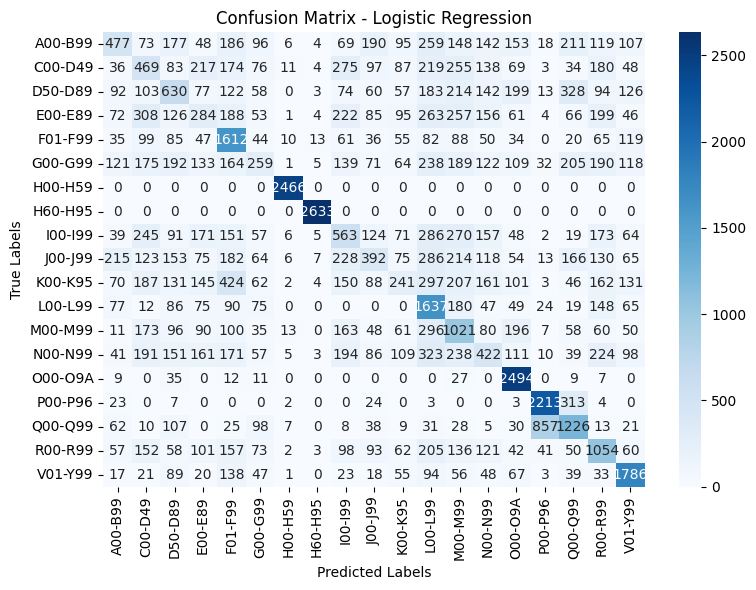

Accuracy - Logistic Regression: 0.44938996836873024



c:\Users\estra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Confusion Matrix - Logistic Regression (Balanced):


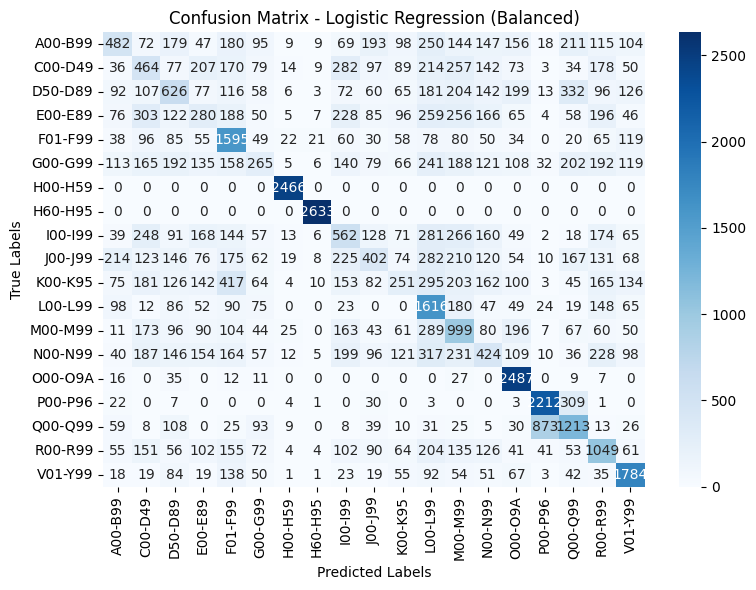

Accuracy - Logistic Regression (Balanced): 0.44797272316477016



c:\Users\estra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Confusion Matrix - Logistic Regression (SMOTE):


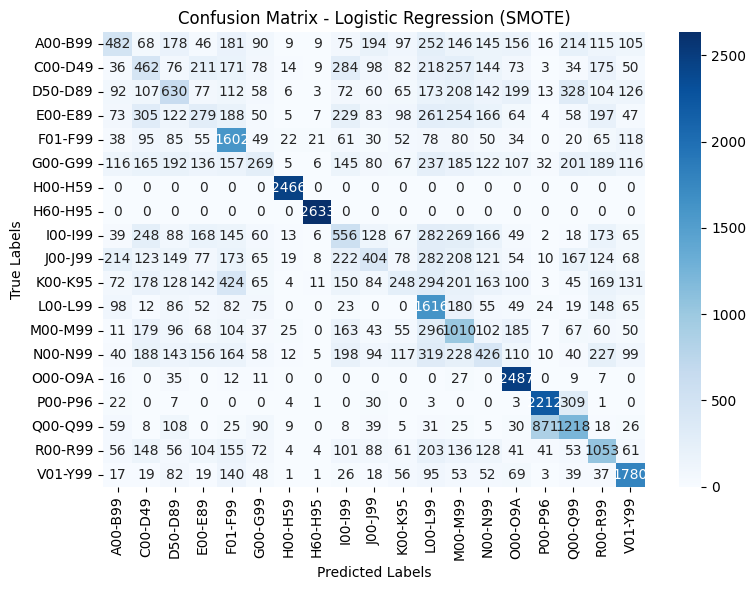

Accuracy - Logistic Regression (SMOTE): 0.44844513823275683



In [5]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

logistic_regression_models = [
    (
        "Logistic Regression",
        LogisticRegression(
            random_state=42, C=1, solver="saga", penalty="l1"
        ),
    ),
    (
        "Logistic Regression (Balanced)",
        LogisticRegression(
            random_state=42,
            class_weight="balanced",
            solver="saga",
            penalty="l2",
        ),
    ),
    (
        "Logistic Regression (SMOTE)",
        make_pipeline(
            SMOTE(random_state=42),
            LogisticRegression(random_state=42, solver="saga"),
        ),
    ),
]

for model_name, model in logistic_regression_models:
    pipeline = create_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    evaluate_model(pipeline, X_test, y_test, model_name)

In [7]:
decision_tree_models = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42, max_depth=5)),
    (
        "Decision Tree (Balanced)",
        DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    ),
    (
        "Decision Tree (SMOTE)",
        make_pipeline(SMOTE(random_state=42), DecisionTreeClassifier(random_state=42)),
    ),
]

### Suport Vector Machine 

In [ ]:
from sklearn.svm import SVC

# Define modelos SVM
svm_models = [
    ("SVM", SVC(random_state=42, kernel='rbf', C=1.0)),
    ("SVM (Balanced)", SVC(random_state=42, kernel='rbf', class_weight='balanced', C=1.0)),
]

# Itera sobre cada modelo SVM
for model_name, model in svm_models:
    # Crea un pipeline con preprocesamiento y modelo SVM
    pipeline = create_pipeline(preprocessor, model)
    
    # Entrena el modelo en los datos de entrenamiento
    pipeline.fit(X_train, y_train)
    
    # Evalúa el rendimiento del modelo
    evaluate_model(pipeline, X_test, y_test, model_name)


#### Mejores parámetros

In [9]:
from sklearn.model_selection import GridSearchCV

# Define los parámetros que deseas probar
param_grid = {
    'model__C': [0.1, 1, 10],  # Parámetro de regularización
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Tipo de kernel
}

# Carga los datos simplificados
defunciones_simplified = pd.read_csv("defunciones_simplified.csv")

# Separa características y variable objetivo
X = defunciones_simplified.drop('causa', axis=1)
y = defunciones_simplified['causa']

# Aplica la división de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crea un pipeline con preprocesamiento y modelo SVM
pipeline = create_pipeline(preprocessor, SVC(random_state=42))

# Inicializa la búsqueda de cuadrícula con validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Realiza la búsqueda de cuadrícula en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtiene los mejores parámetros y el mejor rendimiento
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Imprime los mejores parámetros y el mejor rendimiento
print("Mejores Parámetros:", best_params)
print("Mejor Rendimiento (Precisión):", best_score)

